# Elastic deformation (Dead Sea shape)

## Tools

*Modules*

In [1]:
import numpy as np
from scipy.special import ellipe, ellipk
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pyproj import Transformer
import pandas as pd
import json

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.cm as cmx
import matplotlib.ticker as ti
from matplotlib import patheffects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmcrameri.cm as cmc
from astropy.time import Time
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cf
import pygmt
from pygmt.datasets import load_earth_relief
from fontTools.ttLib import TTFont
from matplotlib.font_manager import fontManager, FontProperties

In [2]:
plt.style.use('myfig.mplstyle')

*Paths*

In [3]:
# paths
wkdir = "/Users/emile/Documents/Etude/2024_2025_M2/tutored_project"
datadir = "{:}/data".format(wkdir)
plotdir = "{:}/figures".format(wkdir)

*Dead Sea shapefile*

In [4]:
crs_geo = 'EPSG:4326'
crs_utm = 'EPSG:32636'

In [5]:
dead_sea_shp_geo = gpd.read_file("{:}/Dead_sea_shapefile/dead_sea.shp".format(datadir))
dead_sea_shp_utm = dead_sea_shp_geo.to_crs(crs_utm)

In [6]:
x_dead_sea, y_dead_sea = dead_sea_shp_utm.geometry[0].exterior.xy
x_dead_sea = np.array(x_dead_sea)
y_dead_sea = np.array(y_dead_sea)

*Import mesh*

In [7]:
res = 8

mesh_disk_geo = pd.read_csv("{:}/Dead_Sea_mesh/mesh_geo_res{:}.txt".format(datadir, res), sep='\t')
mesh_disk_utm = pd.read_csv("{:}/Dead_Sea_mesh/mesh_utm_res{:}.txt".format(datadir, res), sep='\t')

Ndisk = len(mesh_disk_geo)

*Import InSAR data*

In [8]:
threshold_nbinterf = 1000.
threshold_rms = .8

In [9]:
insar_asc_vel = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_asc_vel.npy".format(datadir))
insar_asc_mask_nodata = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_asc_mask_nodata.npy".format(datadir))
insar_asc_vel[insar_asc_mask_nodata] = np.nan

insar_asc_lon = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_asc_lon.npy".format(datadir))
insar_asc_lat = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_asc_lat.npy".format(datadir))

insar_asc_x = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_asc_x_utm.npy".format(datadir))
insar_asc_y = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_asc_y_utm.npy".format(datadir))

insar_asc_LOS = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_asc_LOS.npy".format(datadir))
insar_asc_LOS_mean = np.mean(insar_asc_LOS, axis=(0, 1))

insar_asc_nbinterf = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_asc_nbinterf.npy".format(datadir))
insar_asc_misclosure = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_asc_misclosure.npy".format(datadir))
insar_asc_coherence = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_asc_coherence.npy".format(datadir))

In [10]:
mask_asc = insar_asc_nbinterf == 0.

insar_asc_vel[mask_asc] = np.nan
insar_asc_misclosure[mask_asc] = np.nan
insar_asc_coherence[mask_asc] = np.nan
insar_asc_nbinterf[mask_asc] = np.nan

In [11]:
insar_asc_vel[insar_asc_nbinterf <= threshold_nbinterf] = np.nan
insar_asc_vel[insar_asc_misclosure >= threshold_rms] = np.nan

In [12]:
insar_desc_vel = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_desc_vel.npy".format(datadir))
insar_desc_mask_nodata = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_desc_mask_nodata.npy".format(datadir))
insar_desc_vel[insar_desc_mask_nodata] = np.nan

insar_desc_lon = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_desc_lon.npy".format(datadir))
insar_desc_lat = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_desc_lat.npy".format(datadir))

insar_desc_x = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_desc_x_utm.npy".format(datadir))
insar_desc_y = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_desc_y_utm.npy".format(datadir))

insar_desc_LOS = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_desc_LOS.npy".format(datadir))
insar_desc_LOS_mean = np.mean(insar_desc_LOS, axis=(0, 1))

insar_desc_nbinterf = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_desc_nbinterf.npy".format(datadir))
insar_desc_misclosure = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_desc_misclosure.npy".format(datadir))
insar_desc_coherence = np.load("{:}/InSAR_FLATSIM/numpy_format/insar_desc_coherence.npy".format(datadir))

In [13]:
mask_desc = insar_desc_nbinterf == 0.

insar_desc_vel[mask_desc] = np.nan
insar_desc_misclosure[mask_desc] = np.nan
insar_desc_coherence[mask_desc] = np.nan
insar_desc_nbinterf[mask_desc] = np.nan

In [14]:
insar_desc_vel[insar_desc_nbinterf <= threshold_nbinterf] = np.nan
insar_desc_vel[insar_desc_misclosure >= threshold_rms] = np.nan

In [15]:
# Reference velocities to a stable region
# Tel-Aviv GNSS station

insar_lon_ref = 34.781
insar_lat_ref = 32.068

transformer = Transformer.from_crs(crs_geo, crs_utm)
insar_x_ref, insar_y_ref = transformer.transform(insar_lat_ref, insar_lon_ref)

insar_asc_iref = np.unravel_index(np.argmin(np.sqrt((insar_asc_x - insar_x_ref)**2 + (insar_asc_y - insar_y_ref)**2)), insar_asc_x.shape)
insar_desc_iref = np.unravel_index(np.argmin(np.sqrt((insar_desc_x - insar_x_ref)**2 + (insar_desc_y - insar_y_ref)**2)), insar_desc_x.shape)

step = 2

insar_asc_vel_ref = np.nanmean(insar_asc_vel[insar_asc_iref[0]-step:insar_asc_iref[0]+step+1 , insar_asc_iref[1]-step:insar_asc_iref[1]+step+1])
insar_desc_vel_ref = np.nanmean(insar_desc_vel[insar_desc_iref[0]-step:insar_desc_iref[0]+step+1 , insar_desc_iref[1]-step:insar_desc_iref[1]+step+1])

insar_asc_vel -= insar_asc_vel_ref
insar_desc_vel -= insar_desc_vel_ref

In [16]:
# InSAR time periods
insar_asc_tinf = '2015-03-04'
insar_asc_tsup = '2021-04-25'

insar_desc_tinf = '2014-10-31'
insar_desc_tsup = '2021-04-27'

insar_asc_tinf_yr = Time(insar_asc_tinf).decimalyear
insar_asc_tsup_yr = Time(insar_asc_tsup).decimalyear

insar_desc_tinf_yr = Time(insar_desc_tinf).decimalyear
insar_desc_tsup_yr = Time(insar_desc_tsup).decimalyear

*Dead Sea water level*

In [17]:
# Dead sea level (1976 - 2024)

with open("{:}/Dead_Sea_level/Dead_Sea_level_1976_2024.json".format(datadir)) as f:
    dead_sea_level = json.load(f)

dead_sea_level = pd.DataFrame(dead_sea_level['result']['records'])
dead_sea_level["date"] = pd.to_datetime(dead_sea_level["תאריך מדידה"], format="%d/%m/%Y")
dead_sea_level["sea_level"] = dead_sea_level["מפלס"].astype('float64')
dead_sea_level = dead_sea_level.drop(labels=['_id', 'תאריך מדידה', 'מפלס'], axis=1)
dead_sea_level.sort_values('date', inplace=True)
dead_sea_level.reset_index(drop=True, inplace=True)
dead_sea_level['decimal_year'] = np.array([Time(t, format='datetime').decimalyear for t in dead_sea_level["date"]])

In [18]:
insar_desc_hinf = dead_sea_level.iloc[np.argmin(np.abs(dead_sea_level.date - datetime.strptime(insar_desc_tinf, '%Y-%m-%d')))].sea_level
insar_desc_hsup = dead_sea_level.iloc[np.argmin(np.abs(dead_sea_level.date - datetime.strptime(insar_desc_tsup, '%Y-%m-%d')))].sea_level
insar_desc_dh = insar_desc_hsup - insar_desc_hinf

insar_asc_hinf = dead_sea_level.iloc[np.argmin(np.abs(dead_sea_level.date - datetime.strptime(insar_asc_tinf, '%Y-%m-%d')))].sea_level
insar_asc_hsup = dead_sea_level.iloc[np.argmin(np.abs(dead_sea_level.date - datetime.strptime(insar_asc_tsup, '%Y-%m-%d')))].sea_level
insar_asc_dh = insar_asc_hsup - insar_asc_hinf

*Functions*

In [19]:
def elastic_vertical_displacement(r, p, a, nu, E):
    """
    This function computes the vertical displacement of the
    surface generated by a uniform load over a circular area
    at a given distance.
    
    From:
    
    Verruijt, A. (2010). Elastodynamics of a Half Space.
    In: An Introduction to Soil Dynamics. Theory and Applications
    of Transport in Porous Media, vol 24. Springer,
    Dordrecht. https://doi.org/10.1007/978-90-481-3441-0_9
    
    Johnson, K. L. (1987). Contact mechanics. Cambridge University Press.

    Args:
        r (array of floats): distance at which the surface displacement is computed (m)
        p (float): load over the circular area (Pa)
        a (float): radius of the circular loaded area (m)
        nu (float): Poisson's ratio of the encasing rock
        E (float): Young's modulus of the encasing rock (Pa)
    """
    
    u = np.zeros_like(r)
    
    x = r**2/a**2
    u[r <= a] = - 4*p*a*(1-nu**2)/(np.pi*E)*ellipe(x[r <= a])
    u[r > a] = - 4*p*r[r > a]*(1-nu**2)/(np.pi*E)*(ellipe(1/x[r > a])-(1-1/x[r > a])*ellipk(1/x[r > a]))
    
    return u


def elastic_radial_displacement(r, p, a, nu, E):
    """
    This function computes the radial displacement of the
    surface generated by a uniform load over a circular area
    at a given distance.
    
    From:
    
    Verruijt, A. (2010). Elastodynamics of a Half Space.
    In: An Introduction to Soil Dynamics. Theory and Applications
    of Transport in Porous Media, vol 24. Springer,
    Dordrecht. https://doi.org/10.1007/978-90-481-3441-0_9
    
    Johnson, K. L. (1987). Contact mechanics. Cambridge University Press.

    Args:
        r (array of floats): distance at which the surface displacement is computed (m)
        p (float): load over the circular area (Pa)
        a (float): radius of the circular loaded area (m)
        nu (float): Poisson's ratio of the encasing rock
        E (float): Young's modulus of the encasing rock (Pa)
    """
    
    u = np.zeros_like(r)
    
    x = r**2/a**2
    u[r <= a] = - (1-2*nu)*(1+nu)/(2*E)*p*r[r <= a]
    u[r > a] = - (1-2*nu)*(1+nu)/(2*E)*p*a**2/r[r > a]
    
    return u


def found_font_with_unicode_char(list_unichars):
    
    def char_in_font(unicode_char, font):
        if font.endswith('.ttc'):
            fontNo = 0
        else:
            fontNo = -1
        font = TTFont(font, fontNumber=fontNo)
        for cmap in font['cmap'].tables: 
            if cmap.isUnicode():
                for i in unicode_char:
                    if ord(i) not in cmap.cmap:
                        return False
        return True

    font_list = [(f.fname, f.name) for f in fontManager.ttflist]
    for font in font_list:
        if char_in_font(list_unichars, font[0]):
            return FontProperties(fname=font[0])
    
    return None


def draw_scalebar(ax, length, location=(.9, .9), linewidth=3, units='km', m_per_unit=1000):    
    """
    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    
    def utm_from_lon(lon):
        """
        utm_from_lon - UTM zone for a longitude
        Not right for some polar regions (Norway, Svalbard, Antartica)
        :param float lon: longitude
        :return: UTM zone number
        :rtype: int
        """
        return int(np.floor((lon+180)/6)+1)
    
    proj = ax.projection
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
            linewidth=linewidth, path_effects=buffer)
    # Plot the scalebar label
    ax.text(sbcx, sbcy+(y1 - y0)*0.01, '{:} {:}'.format(length, units), transform=utm,
            ha='center', va='bottom', path_effects=buffer, zorder=2)
    return


def draw_north_arrow(ax, location=(.1, .9)):    
    """
    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    
    def utm_from_lon(lon):
        """
        utm_from_lon - UTM zone for a longitude
        Not right for some polar regions (Norway, Svalbard, Antartica)
        :param float lon: longitude
        :return: UTM zone number
        :rtype: int
        """
        return int(np.floor((lon+180)/6)+1)
    
    proj = ax.projection
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the arow location into coordinates in metres
    sbcx = x0 + (x1 - x0) * location[0]
    sbcy = y0 + (y1 - y0) * location[1]
    # buffer and plot
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    ax.text(sbcx, sbcy, u'\u25B2\nN', fontproperties=found_font_with_unicode_char([u"\u25B2"]),
            transform=utm, ha='center', va='bottom', path_effects=buffer)
    return

## Surface displacements : realistic geometry + InSAR acquisition points

*Physical parameters*

In [20]:
# Poisson's ratio (encasing rock of the Dead Sea)
nu = .3

# Young's modulus (encasing rock of the Dead Sea)
E = 100e9 # Pa

# Gravity acceleration
g = 9.81 # m.s-2

*Load*

In [21]:
# The Dead sea has a surface of ~605 km2 (2016)
disk_radius = mesh_disk_utm.radius.values[0] # m

# The density of the Dead Sea is ~1240 kg.m-3
# Thus we calculate the change in the load
# beware, here, the z-axis points downwards
rho_sea = 1240 # kg.m-3

p_asc = rho_sea * insar_asc_dh * g
p_desc = rho_sea * insar_desc_dh * g

*InSAR acquisition points*

In [22]:
lonmin, lonmax = 34.5, 36.5
latmin, latmax = 30, 32.5

mask_zone_asc = np.ix_(np.logical_and(insar_asc_lat[:, 0] >= latmin, insar_asc_lat[:, 0] <= latmax),
                       np.logical_and(insar_asc_lon[0, :] >= lonmin, insar_asc_lon[0, :] <= lonmax))

mask_zone_desc = np.ix_(np.logical_and(insar_desc_lat[:, 0] >= latmin, insar_desc_lat[:, 0] <= latmax),
                        np.logical_and(insar_desc_lon[0, :] >= lonmin, insar_desc_lon[0, :] <= lonmax))

In [23]:
insar_asc_Ux = np.zeros_like(insar_asc_lon[mask_zone_asc])
insar_asc_Uy = np.zeros_like(insar_asc_lon[mask_zone_asc])
insar_asc_Uz = np.zeros_like(insar_asc_lon[mask_zone_asc])

for idx, row in mesh_disk_utm.iterrows():
    
    R = np.sqrt((insar_asc_x[mask_zone_asc] - row.x)**2+(insar_asc_y[mask_zone_asc] - row.y)**2)
    
    insar_asc_Uz += elastic_vertical_displacement(R, p_asc, disk_radius, nu, E)
    
    Ur = elastic_radial_displacement(R, p_asc, disk_radius, nu, E)
    
    insar_asc_Ux += (insar_asc_x[mask_zone_asc]-row.x)/np.sqrt((insar_asc_x[mask_zone_asc]-row.x)**2+(insar_asc_y[mask_zone_asc]-row.y)**2) * Ur
    insar_asc_Uy += (insar_asc_y[mask_zone_asc]-row.y)/np.sqrt((insar_asc_x[mask_zone_asc]-row.x)**2+(insar_asc_y[mask_zone_asc]-row.y)**2) * Ur

insar_asc_Uhoriz = np.sqrt(insar_asc_Ux**2+insar_asc_Uy**2)

insar_asc_disp = np.stack((insar_asc_Ux, insar_asc_Uy, insar_asc_Uz), axis=-1)

insar_asc_vel_synthe = - np.sum(insar_asc_disp * insar_asc_LOS[mask_zone_asc], axis=2) / (insar_asc_tsup_yr - insar_asc_tinf_yr
)
insar_asc_vel_synthe[insar_asc_mask_nodata[mask_zone_asc]] = np.nan

In [24]:
insar_desc_Ux = np.zeros_like(insar_desc_lon[mask_zone_desc])
insar_desc_Uy = np.zeros_like(insar_desc_lon[mask_zone_desc])
insar_desc_Uz = np.zeros_like(insar_desc_lon[mask_zone_desc])

for idx, row in mesh_disk_utm.iterrows():
    
    R = np.sqrt((insar_desc_x[mask_zone_desc] - row.x)**2+(insar_desc_y[mask_zone_desc] - row.y)**2)
    
    insar_desc_Uz += elastic_vertical_displacement(R, p_desc, disk_radius, nu, E)
    
    Ur = elastic_radial_displacement(R, p_desc, disk_radius, nu, E)
    
    insar_desc_Ux += (insar_desc_x[mask_zone_desc]-row.x)/np.sqrt((insar_desc_x[mask_zone_desc]-row.x)**2+(insar_desc_y[mask_zone_desc]-row.y)**2) * Ur
    insar_desc_Uy += (insar_desc_y[mask_zone_desc]-row.y)/np.sqrt((insar_desc_x[mask_zone_desc]-row.x)**2+(insar_desc_y[mask_zone_desc]-row.y)**2) * Ur

insar_desc_Uhoriz = np.sqrt(insar_desc_Ux**2+insar_desc_Uy**2)

insar_desc_disp = np.stack((insar_desc_Ux, insar_desc_Uy, insar_desc_Uz), axis=-1)

insar_desc_vel_synthe = - np.sum(insar_desc_disp * insar_desc_LOS[mask_zone_desc], axis=2) / (insar_desc_tsup_yr - insar_desc_tinf_yr)

insar_desc_vel_synthe[insar_desc_mask_nodata[mask_zone_desc]] = np.nan

*Reference*

In [25]:
insar_asc_vel_ref_synthe = np.zeros(3)
insar_desc_vel_ref_synthe = np.zeros(3)
    
for idx, row in mesh_disk_utm.iterrows():
    
    r = np.sqrt((insar_x_ref - row.x)**2+(insar_y_ref - row.y)**2)
    
    # Descending
    
    uz = elastic_vertical_displacement(r, p_desc, disk_radius, nu, E)
    ur = elastic_radial_displacement(r, p_desc, disk_radius, nu, E)
    ux = (insar_x_ref-row.x)/np.sqrt((insar_x_ref-row.x)**2+(insar_y_ref-row.y)**2) * ur
    uy = (insar_y_ref-row.y)/np.sqrt((insar_x_ref-row.x)**2+(insar_y_ref-row.y)**2) * ur
    
    insar_desc_vel_ref_synthe += np.array([ux, uy, uz])
    
    # Ascending
    
    uz = elastic_vertical_displacement(r, p_asc, disk_radius, nu, E)
    ur = elastic_radial_displacement(r, p_asc, disk_radius, nu, E)
    ux = (insar_x_ref-row.x)/np.sqrt((insar_x_ref-row.x)**2+(insar_y_ref-row.y)**2) * ur
    uy = (insar_y_ref-row.y)/np.sqrt((insar_x_ref-row.x)**2+(insar_y_ref-row.y)**2) * ur
    
    insar_asc_vel_ref_synthe += np.array([ux, uy, uz])

insar_asc_vel_ref_synthe = - insar_asc_LOS[insar_asc_iref] @ insar_asc_vel_ref_synthe / (insar_asc_tsup_yr - insar_asc_tinf_yr)
insar_desc_vel_ref_synthe = - insar_desc_LOS[insar_desc_iref] @ insar_desc_vel_ref_synthe / (insar_desc_tsup_yr - insar_desc_tinf_yr)

In [26]:
insar_asc_vel_synthe -= insar_asc_vel_ref_synthe
insar_desc_vel_synthe -= insar_desc_vel_ref_synthe

*Plot*

In [27]:
relief = load_earth_relief(resolution="03s", registration="gridline", region=[lonmin, lonmax, latmin, latmax])
land_grad = pygmt.grdgradient(grid=relief, azimuth=255, normalize='e0.4')

/Users/emile/anaconda3/envs/pygdal/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 2D CRS: GEOGCRS["unknown",DATUM["Unknown based on WGS 84 e ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '
/Users/emile/anaconda3/envs/pygdal/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 2D CRS: GEOGCRS["unknown",DATUM["Unknown based on WGS 84 e ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warni

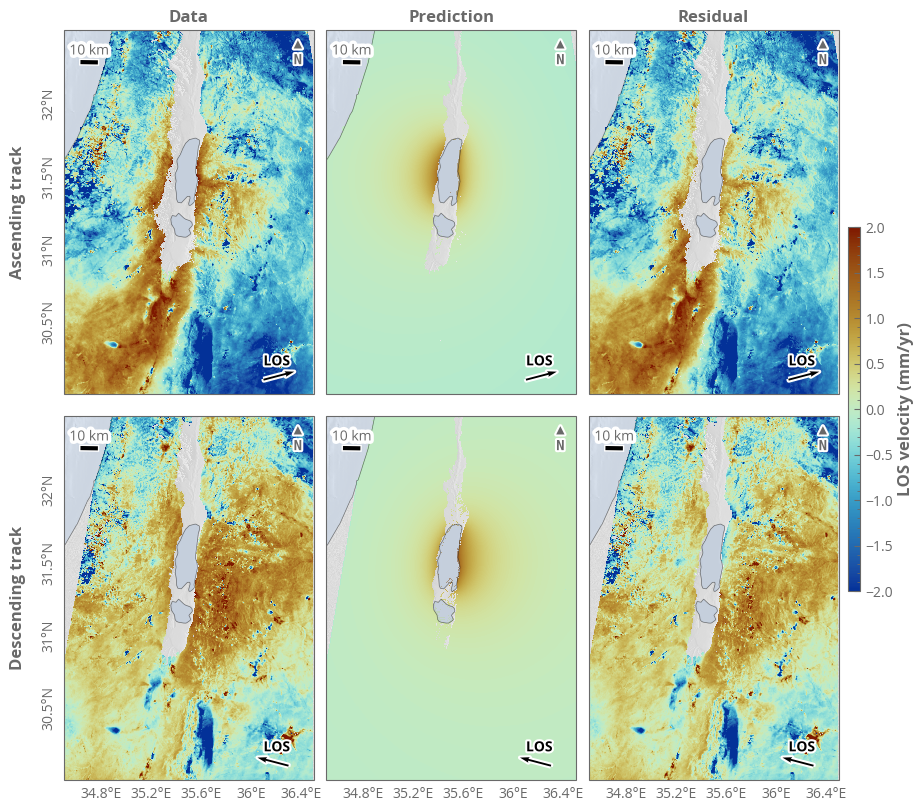

In [28]:
fig, ax = plt.subplots(ncols=3, nrows=2, sharex=True, sharey=True, figsize=(10, 10), subplot_kw={'projection': ccrs.Mercator()})

# map setup

for i in range(2):
    for j in range(3):
            ax[i, j].set_extent([lonmin, lonmax, latmin, latmax])
            ax[i, j].add_feature(cf.OCEAN, facecolor='lightsteelblue', alpha=.5)
            ax[i, j].add_feature(cf.LAND, facecolor='lightgrey', alpha=.5)
            ax[i, j].add_feature(cf.COASTLINE, lw=.5, edgecolor='k', alpha=.5)
            ax[i, j].add_feature(cf.LAKES, linestyle='-', alpha=0.5, lw=.5, facecolor='lightsteelblue', edgecolor='k')
            ax[i, j].pcolormesh(relief.lon, relief.lat, land_grad, cmap=cmc.grayC, transform=ccrs.PlateCarree(), alpha=.1, zorder=-1)
            
            # ax[i, j].add_geometries(dead_sea_shp_geo.geometry, ccrs.PlateCarree(), facecolor='lightgrey', zorder=50)
            
            draw_scalebar(ax[i, j], length=10, location=(.1, .9))
            draw_north_arrow(ax[i, j], location=(.9, .9))
            
            if j == 0:
                gl = ax[i, j].gridlines(draw_labels=True, crs=ccrs.PlateCarree())
                gl.top_labels = False
                gl.bottom_labels = False
                gl.right_labels = False
                gl.xlines = False
                gl.ylines = False
                gl.xlocator = ti.MaxNLocator(5)
                gl.ylocator = ti.MaxNLocator(5)
                gl.ylabel_style = {'rotation': 90}
            
            if i == 1:
                gl = ax[i, j].gridlines(draw_labels=True, crs=ccrs.PlateCarree())
                gl.top_labels = False
                gl.right_labels = False
                gl.left_labels = False
                gl.xlines = False
                gl.ylines = False
                gl.xlocator = ti.MaxNLocator(5)
                gl.ylocator = ti.MaxNLocator(5)
                gl.ylabel_style = {'rotation': 90}

for j in range(3):

    ax[0, j].quiver(np.array([36.1]), np.array([30.1]), np.array([insar_asc_LOS_mean[0]]), np.array([insar_asc_LOS_mean[1]]),
                    transform=ccrs.PlateCarree(), clip_on=False, angles='uv', scale=3, zorder=100, path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
    ax[0, j].text(36.1, 30.2, 'LOS', transform=ccrs.PlateCarree(), fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")], c='k')
    
    ax[1, j].quiver(np.array([36.3]), np.array([30.1]), np.array([insar_desc_LOS_mean[0]]), np.array([insar_desc_LOS_mean[1]]),
                    transform=ccrs.PlateCarree(), clip_on=False, angles='uv', scale=3, zorder=100, path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
    ax[1, j].text(36.1, 30.2, 'LOS', transform=ccrs.PlateCarree(), fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")], c='k')

ax[0, 0].text(-0.15, 0.5, 'Ascending track', va='bottom', ha='center',
              rotation='vertical', rotation_mode='anchor',
              transform=ax[0, 0].transAxes, fontweight='bold', fontsize=12)
ax[1, 0].text(-0.15, 0.5, 'Descending track', va='bottom', ha='center',
              rotation='vertical', rotation_mode='anchor',
              transform=ax[1, 0].transAxes, fontweight='bold', fontsize=12)

cmap = cmc.roma_r
norm = mcolors.Normalize(vmin=-2, vmax=2)
mappable = cmx.ScalarMappable(norm=norm, cmap=cmap)

cax = inset_axes(ax[1, -1], width="5%", height="100%", loc="lower left",
                  bbox_to_anchor=(1.01, .5, 1, 1), bbox_transform=ax[1, -1].transAxes)
cb = fig.colorbar(mappable, cax=cax, orientation='vertical')
cb.set_label('LOS velocity (mm/yr)')

# data

ax[0, 0].set_title('Data')
ax[0, 0].pcolormesh(insar_asc_lon[mask_zone_asc], insar_asc_lat[mask_zone_asc], insar_asc_vel[mask_zone_asc]*10,
                    cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax[1, 0].pcolormesh(insar_desc_lon[mask_zone_desc], insar_desc_lat[mask_zone_desc], insar_desc_vel[mask_zone_desc]*10,
                    cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# prediction

ax[0, 1].set_title('Prediction')
ax[0, 1].pcolormesh(insar_asc_lon[mask_zone_asc], insar_asc_lat[mask_zone_asc], insar_asc_vel_synthe*1e3,
                    cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax[1, 1].pcolormesh(insar_desc_lon[mask_zone_desc], insar_desc_lat[mask_zone_desc], insar_desc_vel_synthe*1e3,
                    cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# residuals

ax[0, 2].set_title('Residual')
ax[0, 2].pcolormesh(insar_asc_lon[mask_zone_asc], insar_asc_lat[mask_zone_asc], insar_asc_vel[mask_zone_asc]*10-insar_asc_vel_synthe*1e3,
                    cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax[1, 2].pcolormesh(insar_desc_lon[mask_zone_desc], insar_desc_lat[mask_zone_desc], insar_desc_vel[mask_zone_desc]*10-insar_desc_vel_synthe*1e3,
                    cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

plt.subplots_adjust(wspace=.05, hspace=.005)
fig.savefig("{:}/elastic_deformation_dead_sea_insar_dataVSsynthe.png".format(plotdir), dpi=300, bbox_inches='tight')
plt.show()